# Read lengths exploration

In [89]:
from datamap import experiment_files, experiments_dict
from Fast5Fetch.fast5fetch.fast5data import get_all_fast5s
from ont_fast5_api.fast5_interface import get_fast5_file
from matplotlib import pyplot as plt

skip = 25
exp_lengths = {}
for k in experiment_files.keys():
    file_lengths = {}
    for f in sorted(experiment_files[k], key=lambda x: int(x.stem.split('_')[-1]))[::skip]:
        print(f.stem)
        lengths = []
        with get_fast5_file(f, mode='r') as f5:
            for i,read in enumerate(f5.get_reads()):
                x = read.get_raw_data(scale=True)
                lengths.append(len(x))
        file_lengths[f.stem]=lengths
    exp_lengths[k]= file_lengths
    print(f'EXP {k} done')


FAR89595_30596c4a_0
FAR89595_30596c4a_25
FAR89595_30596c4a_50
FAR89595_30596c4a_75
FAR89595_30596c4a_100
FAR89595_30596c4a_125
FAR89595_30596c4a_150
FAR89595_30596c4a_175
FAR89595_30596c4a_200
FAR89595_30596c4a_225
FAR89595_30596c4a_250
EXP pos_2022 done
FAR56295_37f312c1_0
FAR56295_37f312c1_25
FAR56295_37f312c1_50
FAR56295_37f312c1_75
FAR56295_37f312c1_100
FAR56295_37f312c1_125
FAR56295_37f312c1_150
FAR56295_37f312c1_175
FAR56295_37f312c1_200
FAR56295_37f312c1_225
FAR56295_37f312c1_250
FAR56295_37f312c1_275
FAR56295_37f312c1_300
FAR56295_37f312c1_325
FAR56295_37f312c1_350
FAR56295_37f312c1_375
FAR56295_37f312c1_400
FAR56295_37f312c1_425
FAR56295_37f312c1_450
FAR56295_37f312c1_475
FAR56295_37f312c1_500
EXP neg_2022 done
FAO56186_d9cbe3d3_0
FAO56186_d9cbe3d3_25
FAO56186_d9cbe3d3_50
FAO56186_d9cbe3d3_75
FAO56186_d9cbe3d3_100
FAO56186_d9cbe3d3_125
EXP pos_2020 done
FAO56097_20250069_0
FAO56097_20250069_25
FAO56097_20250069_50
FAO56097_20250069_75
FAO56097_20250069_100
FAO56097_20250069_12

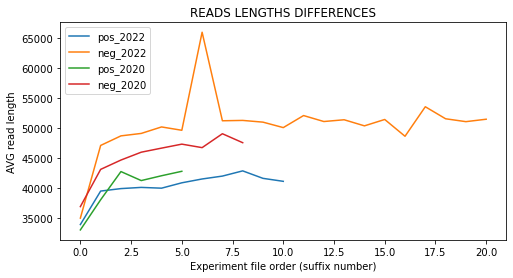

In [90]:
from statistics import mean
# fig, axs = plt.subplots(len(exp_lengths.keys()), sharey=True, figsize=(13,10))
fig, ax = plt.subplots(figsize=(8,4))
for j, (exp, file_lengths) in enumerate(exp_lengths.items()):
    # fig, axs = plt.subplots(len(file_lengths.keys()), sharey=True, figsize=(13,10))
    means = []
    for i,(k,v) in enumerate(file_lengths.items()):
        means.append(int(mean(v)))
        # axs[i].plot(v, label=f'{exp}:MEAN:{int(mean(v))}', color='black')
        # axs[i].legend(loc="upper left")
    ax.plot(means, label=exp)
    
ax.set_title('READS LENGTHS DIFFERENCES')
ax.set_ylabel('AVG read length')
ax.set_xlabel('Experiment file order (suffix number)')
#TODO fix ticks
# ax.set_xticks(range(0,10*skip,skip))
ax.legend(loc="upper left")
pass
#On avg, shorter reads have Modifs, longer do not

# Data standartization/shuffling exploration

In [4]:
from torch.utils.data import DataLoader
from dataloading import get_my_dataset
from datamap import experiment_files

"""
Structure

-experiment0 (positives)
 |
 -fast5file0
     |
     -~4000 reads
 -fast5file1
     |
     -~4000 reads
 -...
-experiment1 (negatives)
 |
 -...
"""

#TODO 2022 vs 2020 data
#TODO window size
#TODO minimum & maximum read lengths
#TODO use fast5 native start-end parameters to speed up training (messes up standartization)

train_dset, valid_dset = get_my_dataset(infinite_random=False, valid_limit=100, valid_files_count=3)

#check if i sample all files equally
counts = {0:0,1:0}
for i in range(100):
    x,y = next(iter(valid_dset))
    counts[(int(y[0]))]+=1
    
counts


{0: 50, 1: 50}

In [6]:
from ont_fast5_api.fast5_interface import get_fast5_file
from pathlib import Path
import random
pos_files = experiment_files['pos_2022']
neg_files = experiment_files['neg_2022']


# print('POSITIVES')
# for file in pos_files:
#     with get_fast5_file(file, mode='r') as f5:
#         print(Path(file).stem, ':',len(list(f5.get_reads())))
        
# print('NEGATIVES')
# for file in neg_files:
#     with get_fast5_file(file, mode='r') as f5:
#         print(Path(file).stem, ':',len(list(f5.get_reads())))

#ALl have 4000 reads inside -> ok to randomize across files


length of a read: 67828
R FAR89595_30596c4a_7
length of a read: 53227
R FAR56295_37f312c1_336


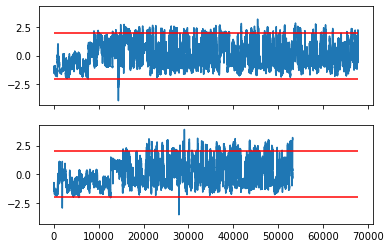

In [7]:
from scipy import stats
import numpy as np
from matplotlib import pyplot as plt
from itertools import islice

def process_fast5_read(read, window, skip=1000, zscore=True, scale=True):
    """ Normalizes and extracts specified region from raw signal """
    
    #zscore normalization matters - computes statistics from the whole sequence
    start = 0
    end = 1000
    cut = False
    stand_before_cut = True
    if(cut and not stand_before_cut):
        s = read.get_raw_data(scale=scale, start=start, end=end)  # Expensive
    else:
        s = read.get_raw_data(scale=scale)  # Expensive
    
    if zscore:
        s = stats.zscore(s)
    print('length of a read:', len(s))
    if(window):
        #TODO why do we skip the first 1000 signals?
        pos = random.randint(skip, len(s)-window)
        print('starting position:',pos)
        return s[pos:pos+window].reshape((window, 1))
    if(cut):
        return s[start:end]
    return s


def myite(files, window, index, zscore, scale):
    while True:
        fast5 = random.choice(files)
        with get_fast5_file(fast5, mode='r') as f5:
            #Visualization shows index-th read of the file
            read = next(islice(f5.get_reads(), index, None))
            x = process_fast5_read(read, window, zscore=zscore, scale=scale)
            print('R',Path(fast5).stem)
            yield x.reshape(-1,1).swapaxes(0,1)

# random.seed(42) #deterministic option
zscore=True
scale=True
ite_pos = myite(pos_files, window=None, index=random.randint(0,100), zscore=zscore, scale=scale) # picking from the first 100 reads
ite_neg = myite(neg_files, window=None, index=random.randint(0,100), zscore=zscore, scale=scale) 
fig, axs = plt.subplots(2, sharey=True, sharex=True)
pos_sample = next(ite_pos)[0]
neg_sample = next(ite_neg)[0]
axs[0].plot(pos_sample)
axs[1].plot(neg_sample)
axs[0].hlines(y=[-2,2], xmin=0, xmax=max(len(pos_sample),len(neg_sample)), colors='red')
axs[1].hlines(y=[-2,2], xmin=0, xmax=max(len(pos_sample),len(neg_sample)), colors='red')


In [14]:
from dataloading import get_my_dataset
from datamap import experiment_files
# get_my_dataset(valid_files_count=3)
# experiment_files['pos_2022']